In [13]:
training_file = 'datasets/oqmd_groundstate.data'
delimiter = ' '
comp_col = 'comp'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
import matminer
import sys
sys.path.append("/Users/Ashwin/Desktop/git/matminer")
from pymatgen import Composition, Element
from matminer.descriptors.composition_features import ElementFractionAttribute
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import datasets
from sklearn import svm
import datetime
from sklearn.multiclass import OneVsRestClassifier
%matplotlib inline

In [15]:
def load_training_set(files, sep):
    if type(files) is not list:
        training_set = pd.read_csv(files, sep=sep)
    else:
        training_set = pd.DataFrame()
        for i in range(len(files)):
            training_set.append(pd.read_csv(files[i], sep=sep[i]))
    
    return training_set

training_set = load_training_set(training_file, delimiter)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# Create PyMatGen Composition Objects

In [16]:
comp_objects = [Composition(comp) for comp in training_set[comp_col]]
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj
0,Pd1,-5.158533,15.20880,None,0.0,0.018186,0.0181856433333,True,(Pd)
1,Hf1,-9.923202,22.36760,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf)
2,In1,-2.714826,26.81600,None,0.0,0.005113,0.00511323666667,True,(In)
3,Mo1,-10.419117,15.92040,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo)
4,Nb1,-9.800921,18.67330,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb)
5,Ni1,-5.552162,10.70220,0.611777266667,0.0,0.014457,0.01445706,True,(Ni)
6,Os1,-11.181135,14.28270,7.71e-05,0.0,0.044841,0.04484125,True,(Os)
7,Pb1,-3.692987,31.17950,None,0.0,0.010978,0.0109780066667,True,(Pb)
8,Pm1,-4.741485,34.23060,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm)
9,Pr1,-4.768796,35.98410,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr)


## Compute element fraction descriptors with MatMiner

In [17]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set)
    training_set_updated = ElementFractionAttribute().featurize_dataframe(training_set, col_id='comp_obj')
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names
all_desc, attr_names = calc_attributes(training_set)
np.shape(all_desc)

CPU times: user 19.7 s, sys: 668 ms, total: 20.4 s
Wall time: 20.6 s


## Predicting formation energy

In [18]:
#Drop invalid rows from training_set

training_set_use = all_desc.replace("None", np.nan)
training_set_use.replace(np.inf, np.nan, inplace=True)
training_set_use.dropna(inplace=True)

np.shape(training_set_use)

(228676, 112)

In [19]:
#Discretize into pos/neg formation energy for classification

delta_e = np.array(training_set_use['delta_e'], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = 'neg'
    else:
        energy_range[i] = 'pos'

print(energy_range)

['p' 'p' 'p' ..., 'n' 'n' 'n']


## ML Models + KFold Cross Validation

In [54]:
from sklearn.model_selection import ShuffleSplit
def shuffle_split_cross_val(model, samples, n_splits=10, test_size=0.3):
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state = 0)
    scores = cross_val_score(model, training_set_use[attr_names], samples, cv=cv)
    print("Average Accuracy: ", scores.mean(), ". Standard Deviation: ", scores.std())

### Random Forest Classifier

In [40]:
%%time
#Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2)
rfc.fit(training_set_use[attr_names], energy_range)
rfc_prediction = rfc.predict(training_set_use[attr_names])

CPU times: user 8.22 s, sys: 418 ms, total: 8.64 s
Wall time: 8.66 s


In [41]:
pd.crosstab(energy_range, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,n,p
actual,,
n,91932,460
p,908,135376


In [42]:
%%time
shuffle_split_cross_val(rfc, energy_range)

Average Accuracy:  0.887385391309 . Standard Deviation:  0.0010623957733
CPU times: user 1min 2s, sys: 1.83 s, total: 1min 3s
Wall time: 1min 4s


### Decision Tree Classifier

In [43]:
dtc = DecisionTreeClassifier()
dtc.fit(training_set_use[attr_names], energy_range)
dtc_prediction = dtc.predict(training_set_use[attr_names])

In [44]:
pd.crosstab(energy_range, dtc_prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,92392,0
p,0,136284


In [46]:
%%time
shuffle_split_cross_val(dtc, energy_range)

Average Accuracy:  0.877474746002 . Standard Deviation:  0.00142362487666
CPU times: user 1min 3s, sys: 911 ms, total: 1min 3s
Wall time: 1min 4s


### Random Forest Regressor

In [47]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [48]:
rf_prediction = rf_model.predict(training_set_use[attr_names])

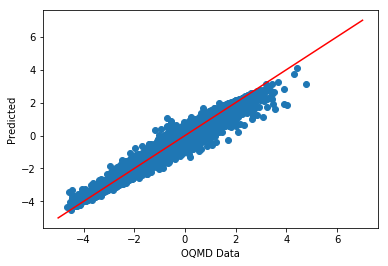

In [49]:
plt.scatter(delta_e, rf_prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [60]:
%%time
shuffle_split_cross_val(rf_model, delta_e)

Average Accuracy:  0.895261521872 . Standard Deviation:  0.0016808473
CPU times: user 7min 26s, sys: 4.85 s, total: 7min 31s
Wall time: 7min 36s


### Decision Forest Regressor

In [52]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_use[attr_names], delta_e)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [56]:
dt_prediction = dt_model.predict(training_set_use[attr_names])

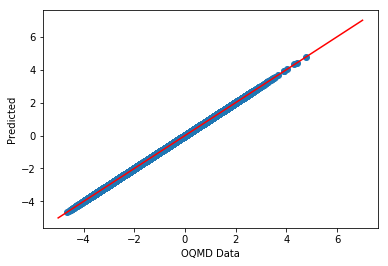

In [57]:
plt.scatter(delta_e, dt_prediction)
plt.plot(range(-5,8), range(-5,8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

In [58]:
%%time
shuffle_split_cross_val(dt_model, delta_e)

Average Accuracy:  0.85118670687 . Standard Deviation:  0.00347414976086
CPU times: user 1min 10s, sys: 1.24 s, total: 1min 11s
Wall time: 1min 12s


# Split Dataset by Element for Aluminum

In [90]:
cols_to_drop = ['comp', 'energy_pa', 'volume_pa', 'magmom_pa', 'bandgap', 'stability', 'comp_obj', 'is_groundstate', 'delta_e']

In [91]:
def get_elements(comp):
    return comp.elements

def split_by_element(training_set, element):
    """
    Splits dataframe into two datasets: one without the element inputted and the other with. Provides datasets for machine learning models.
    
    Args:
        training_set: pandas data frame containing training data
        element: string represenation of an element
    Returns:
        Two dataframes -- one with compounds with the element in it, the other without
    """
    #print(training_set.head())
    #for comp in training_set['comp_obj']:
        #if Element(element) in comp.elements:
        
    training_set['els'] = training_set['comp_obj'].apply(get_elements)
    training_set['is_in'] = False
    for count, el_list in enumerate(training_set['els']):
        if Element(element) in el_list:
            training_set.iloc[count, training_set.columns.get_loc('is_in')] = True
    
    with_element = training_set[training_set['is_in']]
    without_element = training_set[training_set['is_in'] == False]
    return with_element, without_element

In [92]:
%%time
#Predict Enthalpy Delta given training data without Aluminum in it
with_, without = split_by_element(training_set_use, 'Al')

CPU times: user 7.36 s, sys: 267 ms, total: 7.62 s
Wall time: 7.89 s


In [93]:
cols_to_drop += ['els', 'is_in']

In [95]:
def create_ranges(without, with_):
    # Training data

    #Discrete into pos/neg formation energy for regression
    delta_e_without = np.array(without['delta_e'], dtype=float)
    #pos/neg values for classification
    energy_range_without = np.zeros(np.shape(delta_e_without), dtype=str)
    for i in range(len(delta_e_without)):
        if delta_e_without[i] < 0:
            energy_range_without[i] = 'neg'
        else:
            energy_range_without[i] = 'pos'

    # Prediction data
    delta_e_with = np.array(with_['delta_e'], dtype=float)
    energy_range_with = np.zeros(np.shape(delta_e_with), dtype=str)
    for i in range(len(delta_e_with)):
        if delta_e_with[i] < 0:
            energy_range_with[i] = 'neg'
        else:
            energy_range_with[i] = 'pos'
            
    return delta_e_without, energy_range_without, delta_e_with, energy_range_with

In [96]:
delta_e_without, energy_range_without, delta_e_with, energy_range_with = create_ranges(without, with_)

## Classification on All Elements

In [112]:
def all_el_split(method):
    """
    Takes a machine learning model, then uses the split element test to fill a dataframe with r1 and r2 values for each element
    """
    index = ['r1', 'r2']
    stats = pd.DataFrame(index=index)
    for i in range(1, 104):
        el = Element.from_Z(i).symbol
        print(el)
        # creates two dataframes, with the element in it and without the element in it
        with_, without = split_by_element(training_set_use, el)
        # will reiterate if there are no compositions with the selected element
        if with_.shape[0] == 0:
            continue
        # creates classification data: trains with delta_e_without and energy_range_without; predicts with delta_e_with
        delta_e_without, energy_range_without, delta_e_with, energy_range_with = create_ranges(without, with_)
        r1, r2 = method(without, with_, energy_range_without, energy_range_with)
        arr = [r1, r2]
        stats[el] = pd.Series(arr).values 
        
    return stats

### Random Forest Classifier

In [111]:
import math
def rfc(without, with_, energy_range_without, energy_range_with):
    """
    Returns r1 score and r2 score
    """
    
    rfc = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, n_jobs=-1)
    rfc.fit(without.drop(cols_to_drop, axis=1), energy_range_without)
    rfc_prediction = rfc.predict(with_.drop(cols_to_drop, axis=1))
    r2_score = rfc.score(with_.drop(cols_to_drop, axis=1), energy_range_with)
    r1_score = math.sqrt(r2_score)
    #print(pd.crosstab(energy_range_with, rfc_prediction, rownames=['actual'], colnames=['predicted']))
    print(r1_score)
    return r1_score, r2_score


In [113]:
rfc_stats = all_el_split(rfc)

H
0.9025008432243847
He
1.0
Li
0.9576182948390248
Be
0.8789258895892109
B
0.8396961743278847
C
0.8184104673006692
N
0.7930107057167912
O
0.7467932815303101
F
0.8162698707801022
Ne
1.0
Na
0.9201456389113962
Mg
0.9362171221111429
Al
0.8208085188710622
Si
0.7840382576689603
P
0.8669403806944552
S
0.799439525460572
Cl
0.8523561879958644
Ar
1.0
K
0.8916488332407166
Ca
0.9500922464438742
Sc
0.9382249599046204
Ti
0.9038602104407639
V
0.8807643268888364
Cr
0.886786975852238
Mn
0.8955141360255682
Fe
0.8801777606911968
Co
0.8739601176087918
Ni
0.8793537554905224
Cu
0.907286538536476
Zn
0.8847320755724791
Ga
0.8109251782506033
Ge
0.7993507257448852
As
0.7643713201006037
Se
0.801146377682864
Br
0.7963025222108504
Kr
1.0
Rb
0.8728499805852062
Sr
0.9316896318948118
Y
0.9541729732144622
Zr
0.9221639954051025
Nb
0.8804549497188943
Mo
0.8612881919008855
Tc
0.8489605084773546
Ru
0.8441933058620743
Rh
0.8126148270508342
Pd
0.8203877701540041
Ag
0.8972334531279462
Cd
0.8797772732935282
In
0.84969412703009

In [114]:
rfc_stats

,H,He,Li,Be,B,C,N,O,F,Ne,...,Hg,Tl,Pb,Bi,Ac,Th,Pa,U,Np,Pu
r1,0.902501,1.0,0.957618,0.878926,0.839696,0.818410,0.793011,0.746793,0.816270,1.0,...,0.844005,0.854186,0.841319,0.819390,0.946018,0.932747,0.886190,0.884145,0.873506,0.919686
r2,0.814508,1.0,0.917033,0.772511,0.705090,0.669796,0.628866,0.557700,0.666297,1.0,...,0.712345,0.729633,0.707818,0.671399,0.894950,0.870017,0.785332,0.781712,0.763013,0.845822


In [129]:
rfc_stats.T['r2'].describe()

count    89.000000
mean      0.781140
std       0.113708
min       0.557700
25%       0.673727
50%       0.775201
75%       0.893451
max       1.000000
Name: r2, dtype: float64

### Decision Forest Classifier

In [123]:
def dtc(without, with_, energy_range_without, energy_range_with):
    dtc = DecisionTreeClassifier()
    dtc.fit(without.drop(cols_to_drop, axis=1), energy_range_without)
    dtc_prediction = dtc.predict(with_.drop(cols_to_drop, axis=1))
    r2_score = dtc.score(with_.drop(cols_to_drop, axis=1), energy_range_with)
    r1_score = math.sqrt(r2_score)
    print(pd.crosstab(energy_range_with, dtc_prediction, rownames=['actual'], colnames=['predicted']))
    print(r1_score)
    return r1_score, r2_score

In [124]:
dfc_stats = all_el_split(dtc)

H
predicted     n    p
actual              
n          1413  299
p           114  104
0.8865722546382221
He
predicted  p
actual      
p          1
1.0
Li
predicted     n     p
actual               
n          4111   494
p           286  4896
0.9593239505062499
Be
predicted     n     p
actual               
n          1390   451
p          1642  4913
0.8664378950694543
B
predicted     n     p
actual               
n          1538   524
p          2454  5131
0.8314463276423645
C
predicted    n    p
actual             
n          953  368
p          253  237
0.8106142901114963
N
predicted    n    p
actual             
n          968  456
p          262  157
0.7812923889748284
O
predicted     n     p
actual               
n          7373  7075
p           113    49
0.712746949170855
F
predicted     n    p
actual              
n          1024  737
p            16   24
0.7628230102917312
Ne
predicted  p
actual      
p          1
1.0
Na
predicted     n     p
actual               
n          2

predicted     n     p
actual               
n          2312  2537
p           743  3158
0.790659760670073
Hg
predicted     n     p
actual               
n          1878  1425
p          1167  3922
0.8313449426846593
Tl
predicted     n     p
actual               
n          2023  1297
p          1245  4101
0.8406365111190736
Pb
predicted     n     p
actual               
n          2079  1527
p          1197  3921
0.8293117081146003
Bi
predicted     n     p
actual               
n          2188  1928
p          1137  3551
0.8073802014175677
Po
At
Rn
Fr
Ra
Ac
predicted     n     p
actual               
n          2329   162
p           509  5158
0.957992405186082
Th
predicted     n     p
actual               
n          2473   374
p           595  4936
0.9403935016431584
Pa
predicted     n     p
actual               
n          1453   398
p          1410  4770
0.880268350883936
U
predicted     n     p
actual               
n          1521   176
p          1699  4653
0.8758149391726385
Np

In [125]:
dfc_stats

,H,He,Li,Be,B,C,N,O,F,Ne,...,Hg,Tl,Pb,Bi,Ac,Th,Pa,U,Np,Pu
r1,0.886572,1.0,0.959324,0.866438,0.831446,0.810614,0.781292,0.712747,0.762823,1.0,...,0.831345,0.840637,0.829312,0.807380,0.957992,0.940394,0.880268,0.875815,0.863058,0.919478
r2,0.786010,1.0,0.920302,0.750715,0.691303,0.657096,0.610418,0.508008,0.581899,1.0,...,0.691134,0.706670,0.687758,0.651863,0.917749,0.884340,0.774872,0.767052,0.744870,0.845441


In [128]:
dfc_stats.T['r1'].describe()

count    89.000000
mean      0.874681
std       0.074492
min       0.712747
25%       0.812087
50%       0.869467
75%       0.951190
max       1.000000
Name: r1, dtype: float64